In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import os
import random

import numpy as np
import torch
import scipy.io

from experiment import lesion
from experiment import mRNN
from experiment import michaels_load
from experiment import stim
from experiment import utils

CUDA = torch.device(0)
#CUDA = None


In [2]:
mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       cuda=CUDA)

In [3]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path(),
    cuda=CUDA, with_label=True)

# Dataset items are:
#   (michaels network input, trial end indicator, trial len (scalar),
#    target output, class label)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

In [4]:
# The whole dataset
all_data = next(iter(dataloader))

din = all_data[0]
dout = all_data[-2]
trial_end = all_data[1]

dout = utils.trunc_to_trial_end(dout, trial_end)

batch_size = din.shape[0]
trial_len = din.shape[1]
out_dim = dout.shape[-1]


# Batch idx, time, feature
print("Input shape:", din.shape)

# Batch idx, time, muscle idx
print("Output shape:", dout.shape)

Input shape: torch.Size([502, 341, 21])
Output shape: torch.Size([502, 341, 50])


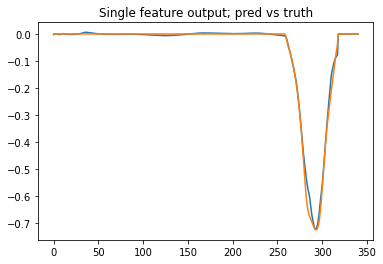

In [5]:
# Ground truth vs. un-lesioned network

preds = torch.empty(batch_size, trial_len, out_dim)
if CUDA:
    preds = preds.cuda(CUDA)

mike.reset()

for tidx in range(trial_len):
    mike_in = din[:, tidx, :].T
    mike_out = mike(mike_in)
    preds[:, tidx, :] = mike_out

preds = utils.trunc_to_trial_end(preds, trial_end)

bidx = random.randrange(batch_size)
fidx = random.randrange(out_dim)
plt.plot(preds[bidx,:,fidx].cpu().detach().numpy())
plt.plot(dout[bidx, :, fidx].cpu().detach().numpy())
plt.title("Single feature output; pred vs truth")
plt.show()

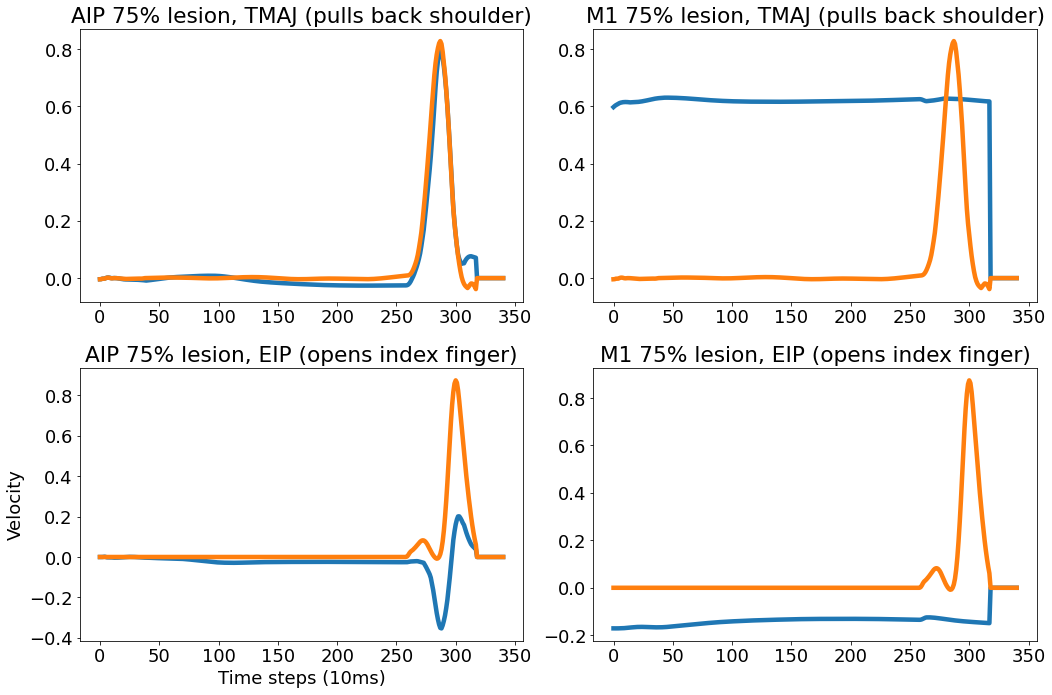

In [21]:
# Now apply some lesions

plt.rc('font', size=18)


# AIP
lesion_instance = lesion.LesionOutputs(100, 'AIP', 0.75, cuda=CUDA)
mike.set_lesion(lesion_instance)
mike.reset()

pred_out_lesion_aip = torch.empty(batch_size, trial_len, out_dim)
if CUDA:
    pred_out_lesion_aip = pred_out_lesion_aip.cuda(CUDA)
for tidx in range(trial_len):
    mike_in = din[:, tidx, :].T
    mike_out = mike(mike_in)
    pred_out_lesion_aip[:, tidx, :] = mike_out
pred_out_lesion_aip = utils.trunc_to_trial_end(pred_out_lesion_aip, trial_end)


# M1
mike.reset_hidden()
lesion_instance = lesion.LesionOutputs(100, 'M1', 0.75, cuda=CUDA)
mike.set_lesion(lesion_instance)

pred_out_lesion_m1 = torch.empty(batch_size, trial_len, out_dim)
if CUDA:
    pred_out_lesion_m1 = pred_out_lesion_m1.cuda(CUDA)
for tidx in range(trial_len):
    mike_in = din[:, tidx, :].T
    mike_out = mike(mike_in)
    pred_out_lesion_m1[:, tidx, :] = mike_out
pred_out_lesion_m1 = utils.trunc_to_trial_end(pred_out_lesion_m1, trial_end)

# Graph it
fig,axs = plt.subplots(2,2, figsize=(15,10))
axs[0,0].plot(pred_out_lesion_aip[bidx,:,7].cpu().detach().numpy(), linewidth=4.5)
axs[0,0].plot(preds[bidx, :, 7].cpu().detach().numpy(), linewidth=4.5)
axs[0,0].set_title("AIP 75% lesion, TMAJ (pulls back shoulder)")
axs[1,0].plot(pred_out_lesion_aip[bidx,:,45].cpu().detach().numpy(), linewidth=4.5)
axs[1,0].plot(dout[bidx, :, 45].cpu().detach().numpy(), linewidth=4.5)
axs[1,0].set_title("AIP 75% lesion, EIP (opens index finger)")
axs[1, 0].set_xlabel("Time steps (10ms)")
axs[1, 0].set_ylabel("Velocity")

axs[0,1].plot(pred_out_lesion_m1[bidx,:,7].cpu().detach().numpy(), linewidth=4.5)
axs[0,1].plot(preds[bidx, :, 7].cpu().detach().numpy(), linewidth=4.5)
axs[0,1].set_title("M1 75% lesion, TMAJ (pulls back shoulder)")
axs[1,1].plot(pred_out_lesion_m1[bidx,:,45].cpu().detach().numpy(), linewidth=4.5)
axs[1,1].plot(dout[bidx, :, 45].cpu().detach().numpy(), linewidth=4.5)
axs[1,1].set_title("M1 75% lesion, EIP (opens index finger)")

mike.set_lesion(None)

fig.tight_layout()
plt.savefig('paper/figs/lesion_trajs.pdf', format='pdf', dpi=150)
plt.show()

In [7]:
# Analyze hand vs reach losses

# Identifies hand vs other muscles
# Based on muscle IDs: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4282829/
hand_muscle_start_idx = 31    # "FDSL" == Flexor digitorum profundus, Digit 5

loss_func = torch.nn.MSELoss()

losses_aip_hand = loss_func(pred_out_lesion_aip[:, :, hand_muscle_start_idx:], preds[:, :, hand_muscle_start_idx:]).cpu().detach().numpy()
losses_aip_other = loss_func(pred_out_lesion_aip[:, :, :hand_muscle_start_idx], preds[:, :, :hand_muscle_start_idx]).cpu().detach().numpy()

losses_m1_hand = loss_func(pred_out_lesion_m1[:, :, hand_muscle_start_idx:], preds[:, :, hand_muscle_start_idx:]).cpu().detach().numpy()
losses_m1_other = loss_func(pred_out_lesion_m1[:, :, :hand_muscle_start_idx], preds[:, :, :hand_muscle_start_idx]).cpu().detach().numpy()

hand_pct_aip = (losses_aip_hand / (losses_aip_hand + losses_aip_other))
hand_pct_m1 = (losses_m1_hand / (losses_m1_hand + losses_m1_other))


In [8]:
print(hand_pct_aip)
print(1-hand_pct_m1)

0.71603036
0.7702908664941788


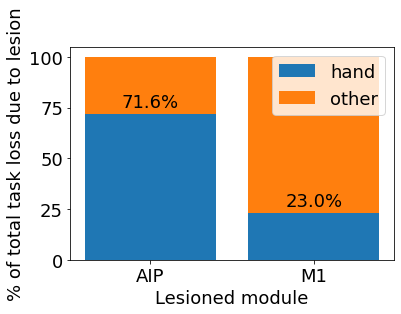

In [27]:

plt.rc('font', size=18)
plt.subplots_adjust(bottom=0.17, left=0.17)

indxs = np.arange(2)

hand_vals = np.array([hand_pct_aip, hand_pct_m1]) * 100.0
other_vals = 100.0 - hand_vals

series = plt.bar(indxs, hand_vals, label="hand")
plt.bar(indxs, other_vals, label="other", bottom=hand_vals)

for s in series:
    height = s.get_height()
    plt.annotate('%0.1f%%' % height,
      xy=(s.get_x() + s.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

plt.xticks(indxs, ["AIP", "M1"])
plt.xlabel("Lesioned module")
plt.ylabel("% of total task loss due to lesion")
plt.legend(loc="upper right")


plt.savefig('paper/figs/lesion_hand.pdf', format='pdf', dpi=150)
plt.show()